<a href="https://colab.research.google.com/github/mayujie/MSC_text_mining/blob/master/CNN_LSTM_BILSTM_big_data_gpu_confusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Analysis with Python

# 1) Importing the data

In [ ]:
import pandas as pd

file_name = 'concatenated.csv'
pd.set_option('display.max_colwidth', -1)

# assign emotion and text to the file
df = pd.read_csv(file_name, names=['text','emotion'], delimiter="\t", header=None)
df.columns = df.iloc[0]
df = df[0:]
from sklearn.utils import shuffle
df = shuffle(df)
print('The data set contains these emotions: {}'.format(set(df['emotion'])))
df = df.sample(frac=1).reset_index(drop=True)
# print out the size of the dataset
print('Size of the dataset: {}'.format(len(df['text'])))

The data set contains these emotions: {'shame', 'sadness', 'joy', 'anger', 'fear', 'disgust', 'guilt'}
Size of the dataset: 100520


In [ ]:
df.groupby('emotion').count()


nan,text
emotion,
anger,14360
disgust,14360
fear,14360
guilt,14360
joy,14360
sadness,14360
shame,14360


Show a sample:

In [ ]:
df['text'][10]

'@eucopresident Maybe the EU should give France a “ little gift “ 👍🇪🇺🇳🇱🇪🇺'

## Show frequency of each class

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.catplot(x="emotion", data=df, kind="count", height=6, aspect=1.5, palette="husl")
plt.show()

<Figure size 900x600 with 1 Axes>

## Extra information on the dataset

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import emoji
import numpy as np

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))

        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        return df

In [ ]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['emotion'] = df.emotion

Descriptive stats for count_words
---------------------------------------------------------------------------------
           count       mean       std  min   25%   50%   75%   max
emotion                                                           
anger    14360.0  13.975000  6.177911  1.0  9.0   13.0  18.0  43.0
disgust  14360.0  13.587047  6.594200  2.0  9.0   12.0  18.0  34.0
fear     14360.0  12.081894  5.745585  1.0  9.0   9.0   15.0  32.0
guilt    14360.0  14.679457  7.203515  2.0  9.0   14.0  20.0  35.0
joy      14360.0  14.724164  6.578250  2.0  9.0   14.0  20.0  34.0
sadness  14360.0  13.562326  5.872441  1.0  9.0   13.0  17.0  34.0
shame    14360.0  14.986908  6.276747  2.0  10.0  15.0  18.0  34.0


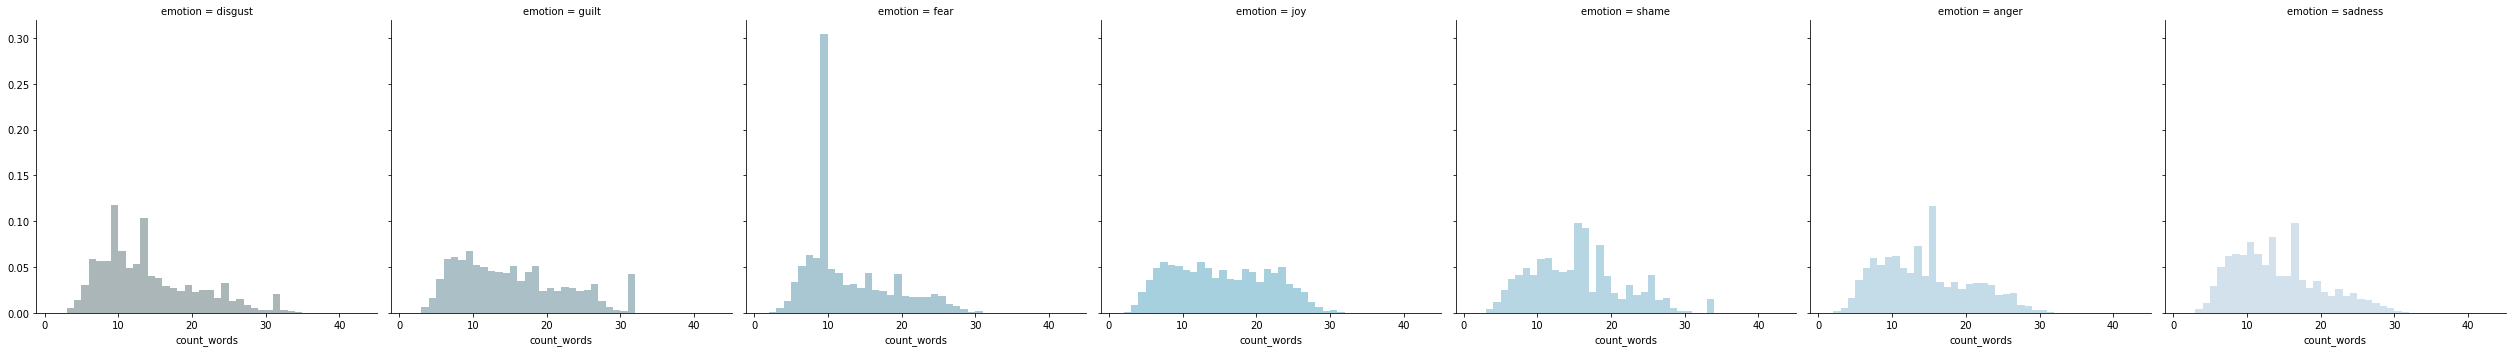

In [ ]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+70))
    print(df.groupby('emotion')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='emotion', height=5, hue='emotion', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

show_dist(df_eda, 'count_words')

# 2°) Data Preprocessing

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import contractions

class CleanText(BaseEstimator, TransformerMixin):
    def __init__(self, neural_network=False):
        self.neural_network = neural_network
    # Remove mentions (@...)
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    # Remove potential urls
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    # Transform emojis to text
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        return input_text.replace('_',' ')

    # Remove punctuation
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    # Remove extra letters
    def reduce_lengthening(self, input_text):
        pattern = re.compile(r"(.)\1{2,}")
        return pattern.sub(r"\1\1", input_text)
    
    # Remove contractions
    def remove_contractions(self, input_text):
        return contractions.fix(input_text)
    
    # Remove digits
    def remove_digits(self, input_text):
        return re.sub(r'\d+', '', input_text)

    # Lower case all the words
    def to_lower(self, input_text):
        return input_text.lower()

    # Remove stopwords or words smaller than 1 character
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

    # Stemming (not used for Neural Network)
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    # Lemmatizing (not used for Neural Network)
    def lemmatizing(self, input_text):
        wordnet_lemmatizer = WordNetLemmatizer()
        words = input_text.split() 
        lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        if(self.neural_network):
            clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_contractions).apply(self.remove_punctuation).apply(self.to_lower).apply(self.reduce_lengthening).apply(self.remove_digits)
        else:
            clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.lemmatizing)
        return clean_X

ct = CleanText(neural_network=True)
#ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

43470     pleading face  pleading face  pleading face  pleading face  pleading face  pleading face  zany face  zany face  zany face  zany face  zany face  zany face you socialists are truly  insane  
30536    love is nothing stronger than a boy with lovee monkey  backhand index pointing left  grinning face  mouth  saxophone  postal horn  thumbs up  droplet  eyes                                   
82848    where is my number one stevetony hype person jan i miss jan can she pls come thru                                                                                                             
62502    rt  look what george bear has been up to today  sun  doughnut                                                                                                                                 
85745    nighttime healy is back                                                                                                                                                                       


In [ ]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


## Stats after preprocessing

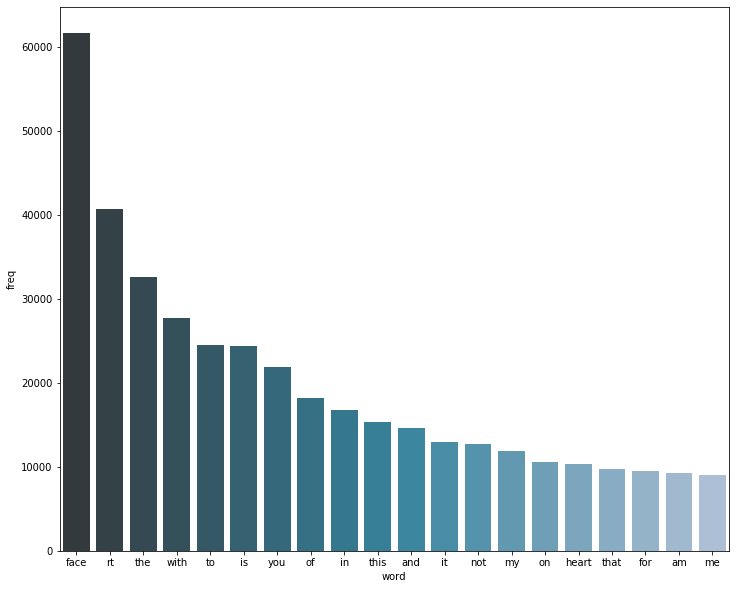

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import collections

# create a bag of words
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)

# Count occurences
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [ ]:
df_model = df_eda
df_model['clean_text'] = sr_clean

In [ ]:
df_model.to_csv(r'./clean_text.csv')

In [ ]:
df_model.dtypes

count_words               int64 
count_mentions            int64 
count_hashtags            int64 
count_capital_words       int64 
count_excl_quest_marks    int64 
count_urls                int64 
count_emojis              int64 
emotion                   object
clean_text                object
dtype: object

In [ ]:
df_model['emotion'].value_counts()

disgust    14360
joy        14360
fear       14360
guilt      14360
sadness    14360
anger      14360
shame      14360
Name: emotion, dtype: int64

In [ ]:
text_list = df_model['clean_text'].tolist()
label_list = df_model['emotion'].tolist()
print("texts {}, labels {}".format(len(text_list),len(label_list)))

texts 100520, labels 100520


In [ ]:
import os
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')          # set up glove directory
MAX_SEQUENCE_LENGTH = 350                              # maximum length of a sequence
MAX_NUM_WORDS = 20000                                   # maximum number of words
#MAX_NUM_WORDS = 40000  
EMBEDDING_DIM = 100                                     # number of dimensions for the embedding layer
TESTING_SPLIT = 0.2

In [ ]:
print('Indexing word vectors.')

# Create a dictionnary (key = word, value = its vector)
embeddings_index = {}                                           
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0] # word is the first item in the list
        coefs = np.asarray(values[1:], dtype='float32') # the rest is its vector
        embeddings_index[word] = coefs # assign the work to its vector

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
#embeddings_index['the']

In [ ]:
print('Processing text dataset')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text_list)

sequences = tokenizer.texts_to_sequences(text_list)
print("Example: \n{} becomes: \n{} ".format(text_list[0],sequences[0]))
max = 0
for sentence in sequences:
    if len(sentence) > max:
        max = len(sentence)
    
print("The longest sequence has {} words".format(max))

Processing text dataset


Using TensorFlow backend.


Example: 
so you going to let your friend nyam fungus and old bacteria   becomes: 
[23, 8, 102, 6, 190, 55, 415, 12334, 6816, 13, 277, 7413] 
The longest sequence has 337 words


In [ ]:
index = tokenizer.word_index
print(len(index))

39059


In [ ]:
import json 
with open( 'word_dict.json' , 'w' ) as file:    
    json.dump( tokenizer.word_index , file )

In [ ]:
# Pad sequences to have the same shape of 350 
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
print(text_list[1])
print(data[1])


rt  heartbreaking  
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39059 unique tokens.


In [ ]:
from keras.utils import to_categorical
labels_dict = {
    'disgust':0,
    'sadness':1, 
    'shame':2, 
    'joy':3, 
    'guilt':4, 
    'fear':5, 
    'anger':6
}

# create a list of all the samples labels
for i in range(0,len(label_list)):
    label_list[i] = labels_dict[label_list[i]]
    

#label_list = np.array(label_list).astype(np.int32)
# create one-hot representati
labels = to_categorical(np.asarray(label_list))
print(labels[0])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

[1. 0. 0. 0. 0. 0. 0.]
Shape of data tensor: (100520, 350)
Shape of label tensor: (100520, 7)


In [ ]:
# split the data into a training set and a validation set
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
#data = data[indices]
#labels = labels[indices]
#num_test_samples = int(TESTING_SPLIT * data.shape[0])

#x_train = data[:-num_test_samples]
#y_train = labels[:-num_test_samples]
#x_test = data[-num_test_samples:]
#y_test = labels[-num_test_samples:]
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (80416, 350)
x_test shape: (20104, 350)
y_train shape: (80416, 7)
y_test shape: (20104, 7)


In [ ]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1

# matrix of 20001 by 350
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# fill the new matrix with dict words
for word, i in word_index.items():
    # if the index is superior to 20 000
    if i > MAX_NUM_WORDS:
        continue
    # get the word
    embedding_vector = embeddings_index.get(word)
    # if the word is not None (aka word is found)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(num_words)
print(embeddings_index.get('face'))

Preparing embedding matrix.
20001
[-0.13234    0.31691    0.67548   -0.29082    0.11674    0.5846
 -0.6859     0.32639   -0.58656   -0.01109   -0.43636    0.34629
  0.1791     0.40488    0.14535   -0.067507  -0.16316    0.43279
 -0.4294    -0.33912   -0.0082742  0.015646   0.068038   0.63244
  0.84129    0.5936     0.27984   -0.61928    0.26884   -0.5104
  0.37507   -0.16799   -0.064193  -0.32503    0.39594   -0.19061
 -0.21194   -0.39461   -0.074421   0.15468   -0.61194   -0.82561
  0.52164   -0.36033   -0.012684   0.30484    0.3812     0.42642
 -0.14906   -0.52745    0.1869    -0.2185    -0.19862    1.6634
  0.26929   -2.0333     0.24169   -0.42761    1.2361     0.43777
  0.25898    0.66032   -0.94538   -0.48365    0.58104   -0.15643
  0.58868    0.47956   -0.64341   -0.21091    0.13704   -0.047705
 -0.63857   -0.37545    0.44312   -0.12098   -0.36055    0.02521
 -0.27534    0.019602   1.4573    -0.093716  -0.39097   -0.056688
 -1.4474    -1.2793    -0.64762    0.57562    0.088322  -

In [ ]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
from keras.initializers import Constant
from keras.layers import Embedding
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed

"""
num_words => input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1. (20001)
EMBEDDING_DIM => 100 (length of a word-vector)
embeddings_initializer: our representation
input_length: Length of input sequences, when it is constant. 
"""


embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
import tensorflow as tf
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [ ]:
print('Training model.')
from keras.models import Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.models import load_model
import keras_metrics
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
print(np.shape(sequence_input))
embedded_sequences = embedding_layer(sequence_input)
print(np.shape(embedded_sequences))
epochs = 15
batch_size = 100
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(256,7, activation='relu'))
model.add(MaxPooling1D(7))
model.add(Conv1D(256, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
#model.add(Flatten())
#model.add(Dense(256))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
#model = load_model('cnn_model_100d.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',keras_metrics.precision(),keras_metrics.recall(),f1,auc])
print(model.summary())
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2, min_delta=0.0001)])

#model.save('cnn_model_100d.h5')

Training model.
(?, 350)
Instructions for updating:
Colocations handled automatically by placer.
(?, 350, 100)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 100)          2000100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 344, 256)          179456    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 43, 256)           459008    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_____________________________________

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])
print('Test precision:',score[2])
print('Test recall:', score[3])
print('Test F1', score[4])
print('Test AUC', score[5])

20104/20104 [==============================] - 2s 111us/step
Test loss score: 1.1647984943231453
Test accuracy: 0.6455929158955895
Test precision: 0.6693325130523121
Test recall: 0.7597765362863207
Test F1 0.6581784979997286
Test AUC 0.9199856446883236


In [ ]:
my_sentences = ["This thesis is terrible. I  need to finish it."]

my_sequences = tokenizer.texts_to_sequences(my_sentences)
my_data = pad_sequences(my_sequences, maxlen=MAX_SEQUENCE_LENGTH)
np.shape(my_data)
pretty_list = ['{}'.format(i) for i in my_data[0]]
new_list = list(map(int, pretty_list))
print(new_list)

pred = model.predict(my_data)

y_classes = pred.argmax(axis=-1)
for emotion, age in labels_dict.items():
    if age == y_classes:
        print(emotion)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
text_labels = list(labels_dict.keys())

In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

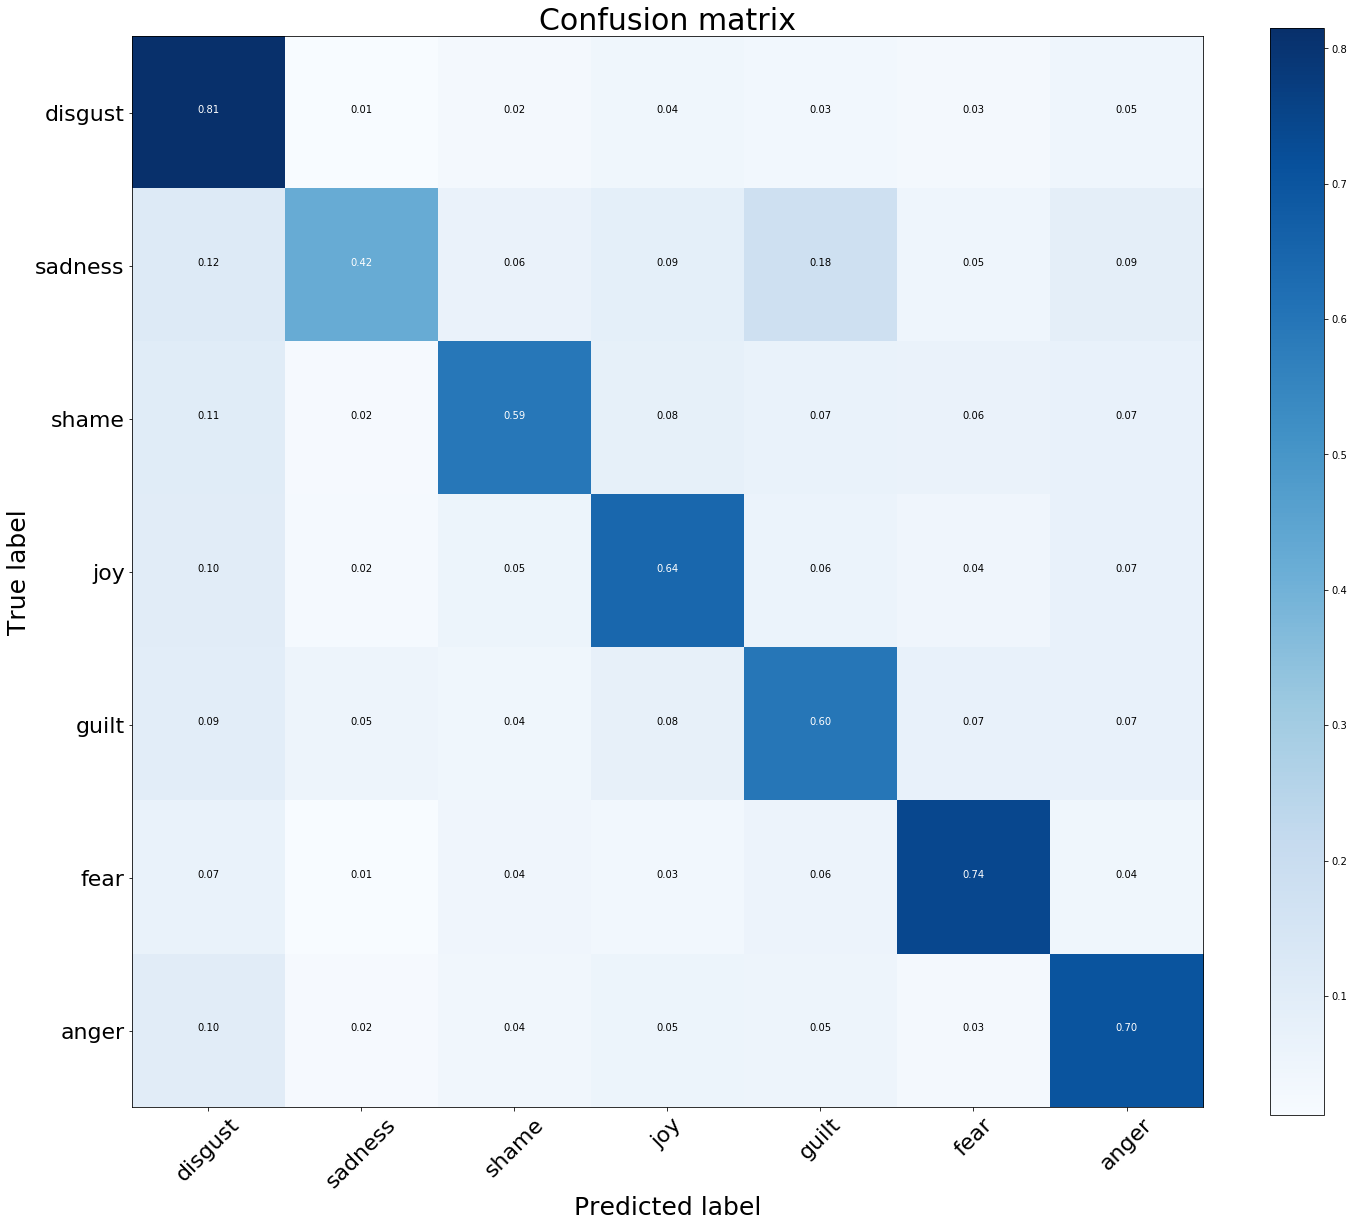

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
model.save('CNN_100D_2Conv.h5')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNLSTM, SpatialDropout1D
#from keras.layers import LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping


epochs = 15
batch_size = 64
lstm_size = 100
model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.5))
#model.add(CuDNNLSTM(lstm_size,return_sequences=True))
#model.add(CuDNNLSTM(lstm_size))
model.add(CuDNNLSTM(lstm_size))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',keras_metrics.precision(),keras_metrics.recall(),f1])
print(model.summary())
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2, min_delta=0.0001)])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 200)          7812000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 350, 200)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
Total params: 7,946,631
Trainable params: 134,631
Non-trainable params: 7,812,000
_________________________________________________________________
None
Train 

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])
print('Test precision:',score[2])
print('Test recall:', score[3])
print('Test F1', score[4])

20104/20104 [==============================] - 3s 150us/step
Test loss score: 1.014233331873841
Test accuracy: 0.6294269797055312
Test precision: 0.8397870280329243
Test recall: 0.5993091536925973
Test F1 0.6273005823250838


In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

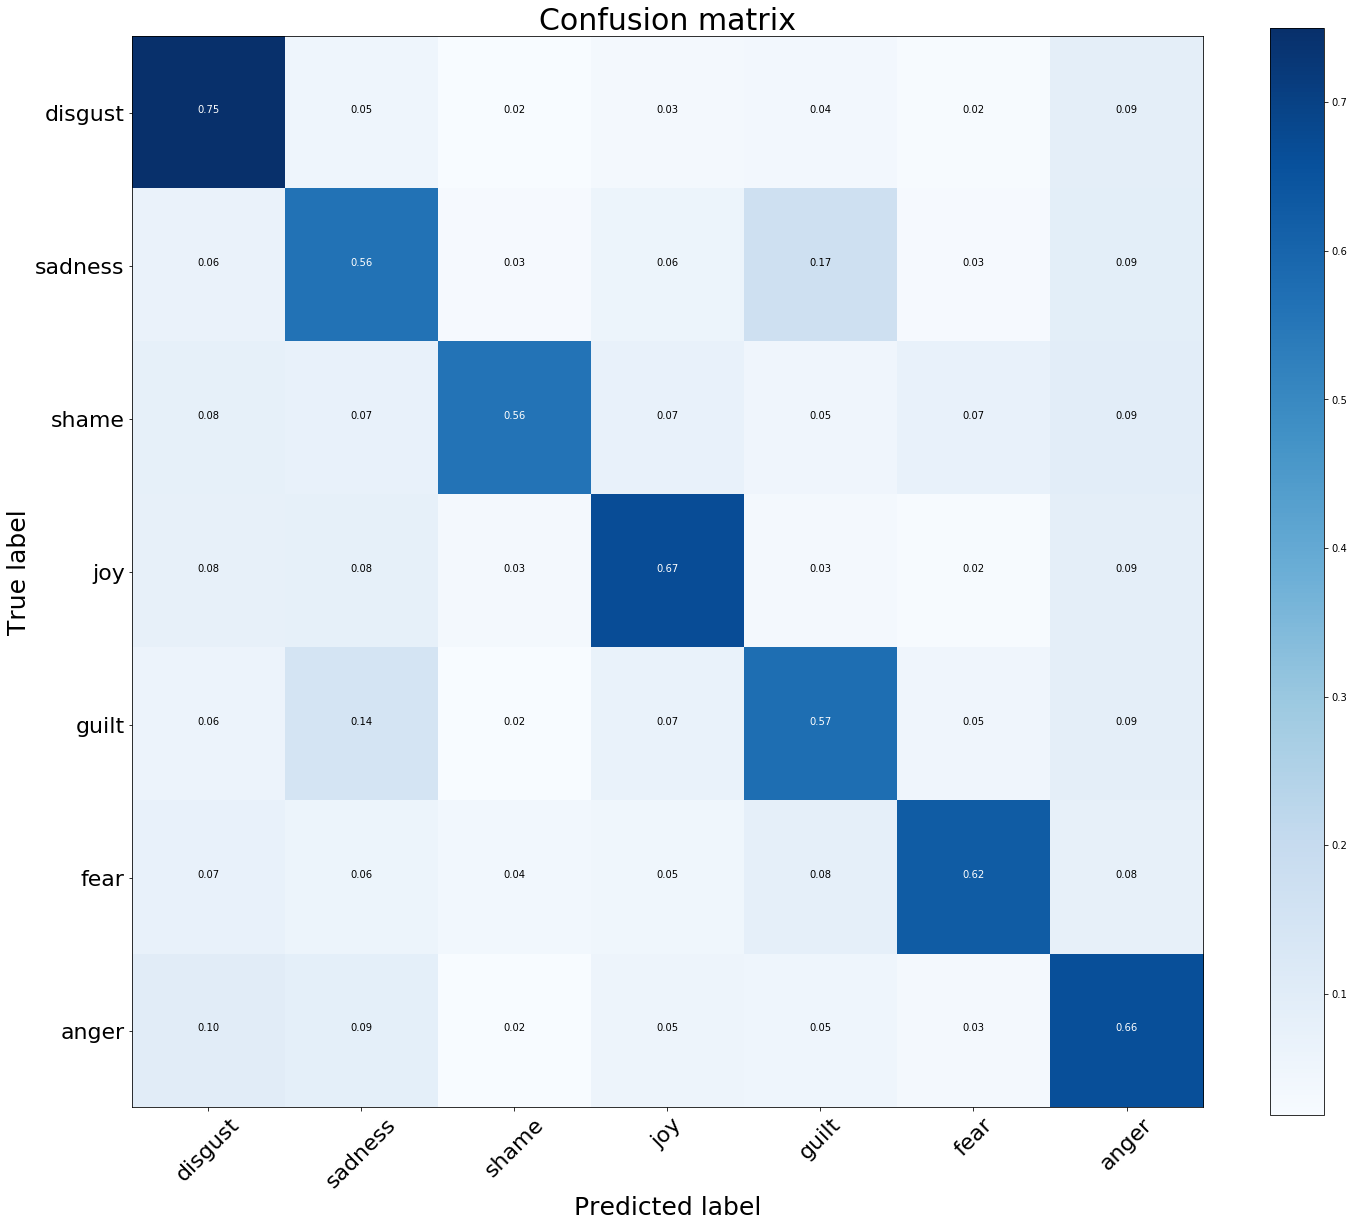

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import CuDNNLSTM, SpatialDropout1D
#from keras.layers import LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping


epochs = 15
batch_size = 64
lstm_size = 100
model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.5))
model.add(CuDNNLSTM(lstm_size,return_sequences=True))
model.add(Conv1D(128,5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 350, 200)          7812000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 350, 200)          0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 350, 100)          120800    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 346, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 69, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 65, 128)           82048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
__________

KeyboardInterrupt: 

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
from keras.models import Sequential
import keras_metrics
from keras.layers import CuDNNLSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Dropout, GlobalMaxPooling1D, Dense
from keras.callbacks import EarlyStopping

epochs = 25
batch_size = 100
lstm_size = 150
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',keras_metrics.precision(),keras_metrics.recall(),f1])
print(model.summary())
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2, min_delta=0.0001)])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 100)          2000100   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 348, 256)          77056     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 2,078,955
Trainable params: 78,855
Non-trainable params: 2,000,100
_________________________________________________________________
None
Train o

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

20104/20104 [==============================] - 1s 55us/step
Test loss score: 1.0068377212751354
Test accuracy: 0.6440509383392865


In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

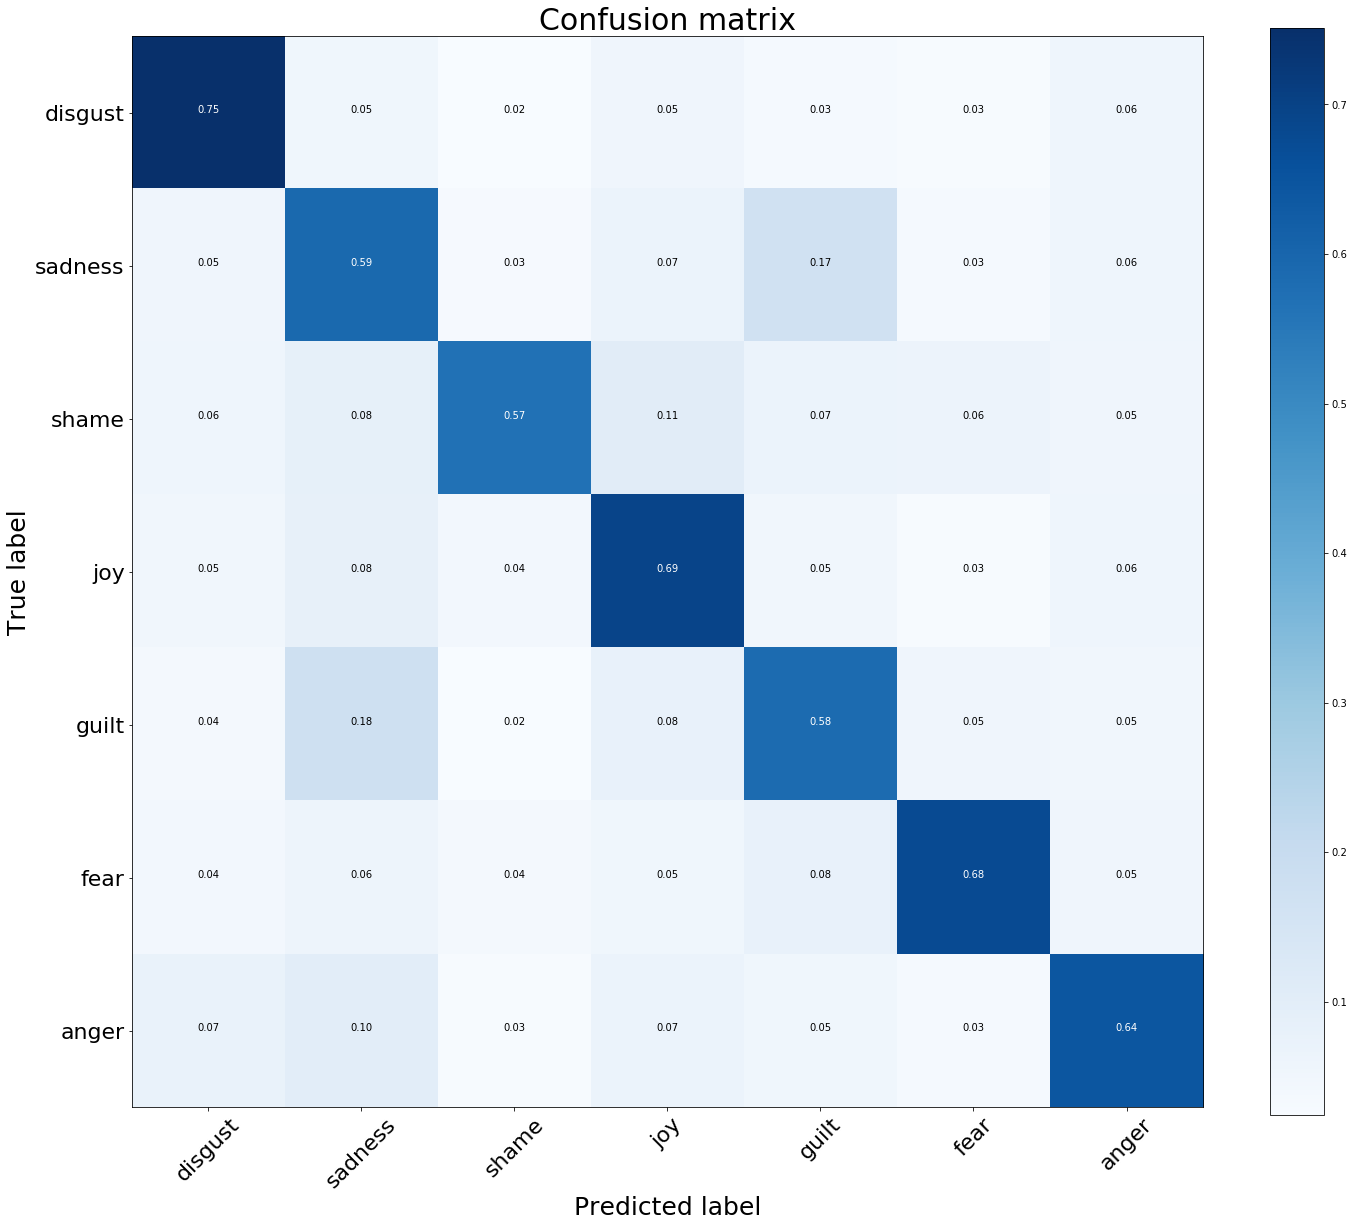

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
import contractions
import re
import emoji
import string
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)
    
    # Remove potential urls
def remove_urls(input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    # Transform emojis to text
def emoji_oneword(input_text):
    # By compressing the underscore, the emoji is kept as one word
    input_text = emoji.demojize(input_text)
    return input_text.replace('_',' ')

    # Remove punctuation
def remove_punctuation(input_text):
        # Make translation table
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
    return input_text.translate(trantab)
    
    # Remove extra letters
def reduce_lengthening(input_text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", input_text)
    
# Remove contractions
def remove_contractions(input_text):
    return contractions.fix(input_text)
    
# Remove digits
def remove_digits(input_text):
    return re.sub(r'\d+', '', input_text)

# Lower case all the words
def to_lower(input_text):
    return input_text.lower()

In [ ]:
from keras.utils import np_utils
sentence = "I am so happy summer is coming !!!"
sentence = remove_mentions(sentence)
sentence = remove_urls(sentence)
sentence = emoji_oneword(sentence)
sentence = remove_contractions(sentence)
sentence = remove_punctuation(sentence)
sentence = reduce_lengthening(sentence)
sentence = remove_digits(sentence)
sentence = to_lower(sentence)
print("Sentence:",sentence)
my_sentences = []
my_sentences.append(sentence)

my_sequences = tokenizer.texts_to_sequences(my_sentences)
my_data = pad_sequences(my_sequences, maxlen=MAX_SEQUENCE_LENGTH)

#print(tf.keras.backend.shape(my_data))
#print(np.shape(my_data))
print(my_data[0])
pred = model.predict(my_data)

y_classes = pred.argmax(axis=-1)


Sentence: i am so happy summer is coming  
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0

In [ ]:
import collections
from collections import Counter 
def pred_2_emotions(y_classes):
    emotion_dict = {
        'disgust':0,
        'sadness':1, 
        'shame':2, 
        'joy':3, 
        'guilt':4, 
        'fear':5, 
        'anger':6
    }
    new_dict = {}
    for emo, index in emotion_dict.items():
        new_dict[emo] = pred[0][index]
    
    k = Counter(new_dict) 
    high = k.most_common(2)
    return high
    
result = pred_2_emotions(y_classes)
print("Result: for {}\n{} with {} % \n{} with {} %".format(sentence, result[0][0],round(result[0][1]*100,2), result[1][0],round(result[1][1]*100,2)))

Result: for i am so happy summer is coming  
joy with 52.06 % 
guilt with 13.58 %


In [ ]:
model.save("CNN_100D_1Conv.h5")